This notebook extracts precipitation timeseries for in districts in Uganda from NASA GPM satalite data

In [1]:
import pandas as pd
import geopandas as gp
from rasterstats import zonal_stats
from affine import Affine
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
from osgeo import gdal
from descartes import PolygonPatch
import datetime
from __future__ import print_function
pd.set_option('io.hdf.default_format', 'table')
%matplotlib inline

/home/nathan/venvs/main/local/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/home/nathan/venvs/main/local/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,ADM0_NAME,ADM1_NAME,ADM2_NAME,Adm_Region,Shape_Area,Shape_Leng,geometry
0,Uganda,Kaabong,Dodoth,Northern,0.591806,4.145036,"POLYGON ((34.09300649600004 3.860423536000042,..."
1,Uganda,Kitgum,Lamwo,Northern,0.449351,3.599283,"POLYGON ((33.32717235000007 3.766835490000062,..."
2,Uganda,Moyo,West Moyo,Northern,0.081616,1.449875,"POLYGON ((31.82121000000006 3.821970000000022,..."
3,Uganda,Yumbe,Aringa,Northern,0.194958,2.389856,"POLYGON ((31.51588987900004 3.639262337000048,..."
4,Uganda,Kitgum,Chua,Northern,0.334961,3.690828,"POLYGON ((33.50670000100007 3.752300000000048,..."
5,Uganda,Koboko,Koboko,Northern,0.061994,1.378402,"POLYGON ((31.07686000000007 3.745340000000056,..."
6,Uganda,Adjumani,Adjumani,Northern,0.251136,2.648423,"POLYGON ((32.04523000000006 3.591670000000022,..."
7,Uganda,Gulu,Kilak,Northern,0.353261,4.608345,"POLYGON ((32.06139403100008 3.579657129000054,..."
8,Uganda,Moyo,Obongi,Northern,0.068809,1.323407,"POLYGON ((31.53577804600008 3.579788923000024,..."
9,Uganda,Arua,Maracha,Northern,0.036492,0.995651,"POLYGON ((30.92056465200005 3.362176895000061,..."


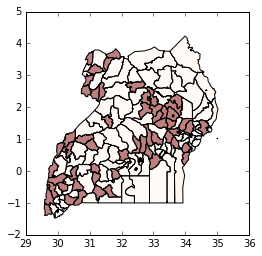

In [2]:
# Load district shape files.
# TODO Clip Lake Victoria?
uganda_shapes = gp.GeoDataFrame.from_file("/home/nathan/Uganda_admin_2014_WGS84.shp")
from shapely.geometry.polygon import Polygon
# Add a weather stations for comparison with on the ground data.
uganda_shapes = uganda_shapes.append(dict(
    ADM0_NAME="Uganda",
    ADM1_NAME="Wakiso",
    ADM2_NAME="HUEN Weather Station",
    geometry=Polygon([[32.444, 0.042], [32.444, 0.052], [32.454, 0.042]])
), ignore_index=True)
uganda_shapes = uganda_shapes.append(dict(
    ADM0_NAME="Kenya",
    ADM1_NAME="Kitale",
    ADM2_NAME="Kitale Weather Station",
    geometry=Polygon([[35, 1.016], [35, 1.026], [35.01, 1.016]])
), ignore_index=True)
uganda_shapes.plot(column='Shape_Area', scheme='QUANTILES', k=3, colormap='OrRd')
uganda_shapes

In [7]:
# An arbitrary file chosen to get coordinates for projection
file_name = "/aux/GPM/201611/3B-HHR-E.MS.MRG.3IMERG.20161121-S070000-E072959.0420.V03E.RT-H5"
with h5py.File(file_name, 'r') as f:
    print("Keys:")
    for key in f['Grid'].keys():
        print(key)
    lons = np.array(f['Grid/lon'])
    lats = np.array(f['Grid/lat'])

Keys:
IRkalmanFilterWeight
HQprecipSource
lon
precipitationCal
precipitationUncal
lat
HQprecipitation
probabilityLiquidPrecipitation
HQobservationTime
randomError
IRprecipitation


In [3]:
import os.path
import copy
def get_total_precipitation(init_date, end_date):
    """
    Get a numpy raster map of the total precipitation over the given date range in millimeters.
    """
    file_name_pattern = ('/aux/GPM/%(year)4d%(month)02d/' +
        '3B-HHR-E.MS.MRG.3IMERG.%(year)4d%(month)02d%(day)02d-' +
        'S%(hour)02d%(minute)02d00-E%(end_hour)02d%(end_minute)02d59.%(minute_of_day)04d.V03E.RT-H5'
    )
    precip_data = None
    iterval_minutes = 30
    count = 0
    start_date = copy.deepcopy(init_date)
    while start_date <= end_date:
        file_name = file_name_pattern % dict(
            year=start_date.year,
            month=start_date.month,
            day=start_date.day,
            hour=start_date.hour,
            minute=start_date.minute,
            end_hour=(start_date + datetime.timedelta(minutes=iterval_minutes - 1)).hour,
            end_minute=(start_date + datetime.timedelta(minutes=iterval_minutes - 1)).minute,
            minute_of_day=(
                start_date - datetime.datetime(start_date.year, start_date.month, start_date.day)
            ).total_seconds() / 60
        )
        start_date += datetime.timedelta(minutes=iterval_minutes)
        try:
            with h5py.File(file_name, 'r') as f:
                d = np.array(f['Grid/precipitationCal'])
                d = np.clip(d, 0, np.inf)
                if precip_data is None:
                    precip_data = d
                else:
                    precip_data += d
                count += 1
        except IOError as e:
            print("WARNING: File does not exist:")
            print(file_name, os.path.isfile(file_name))
            # When a file is missing, we assume the average rainfall for the rest of the
            # time iterval occured during its time period.
            # Usually a missing file is a result of choosing an interval that
            # extends beyond the downloaded data's date range, however there are
            # holes in the data. For example, there is missing data on 2016-3-12 from 12 to 3pm.
            continue
    #in mm/hr
    average_precipitation_rate = precip_data / count
    date_range_hours = (end_date - init_date).total_seconds() / (60 * 60)
    return average_precipitation_rate * date_range_hours

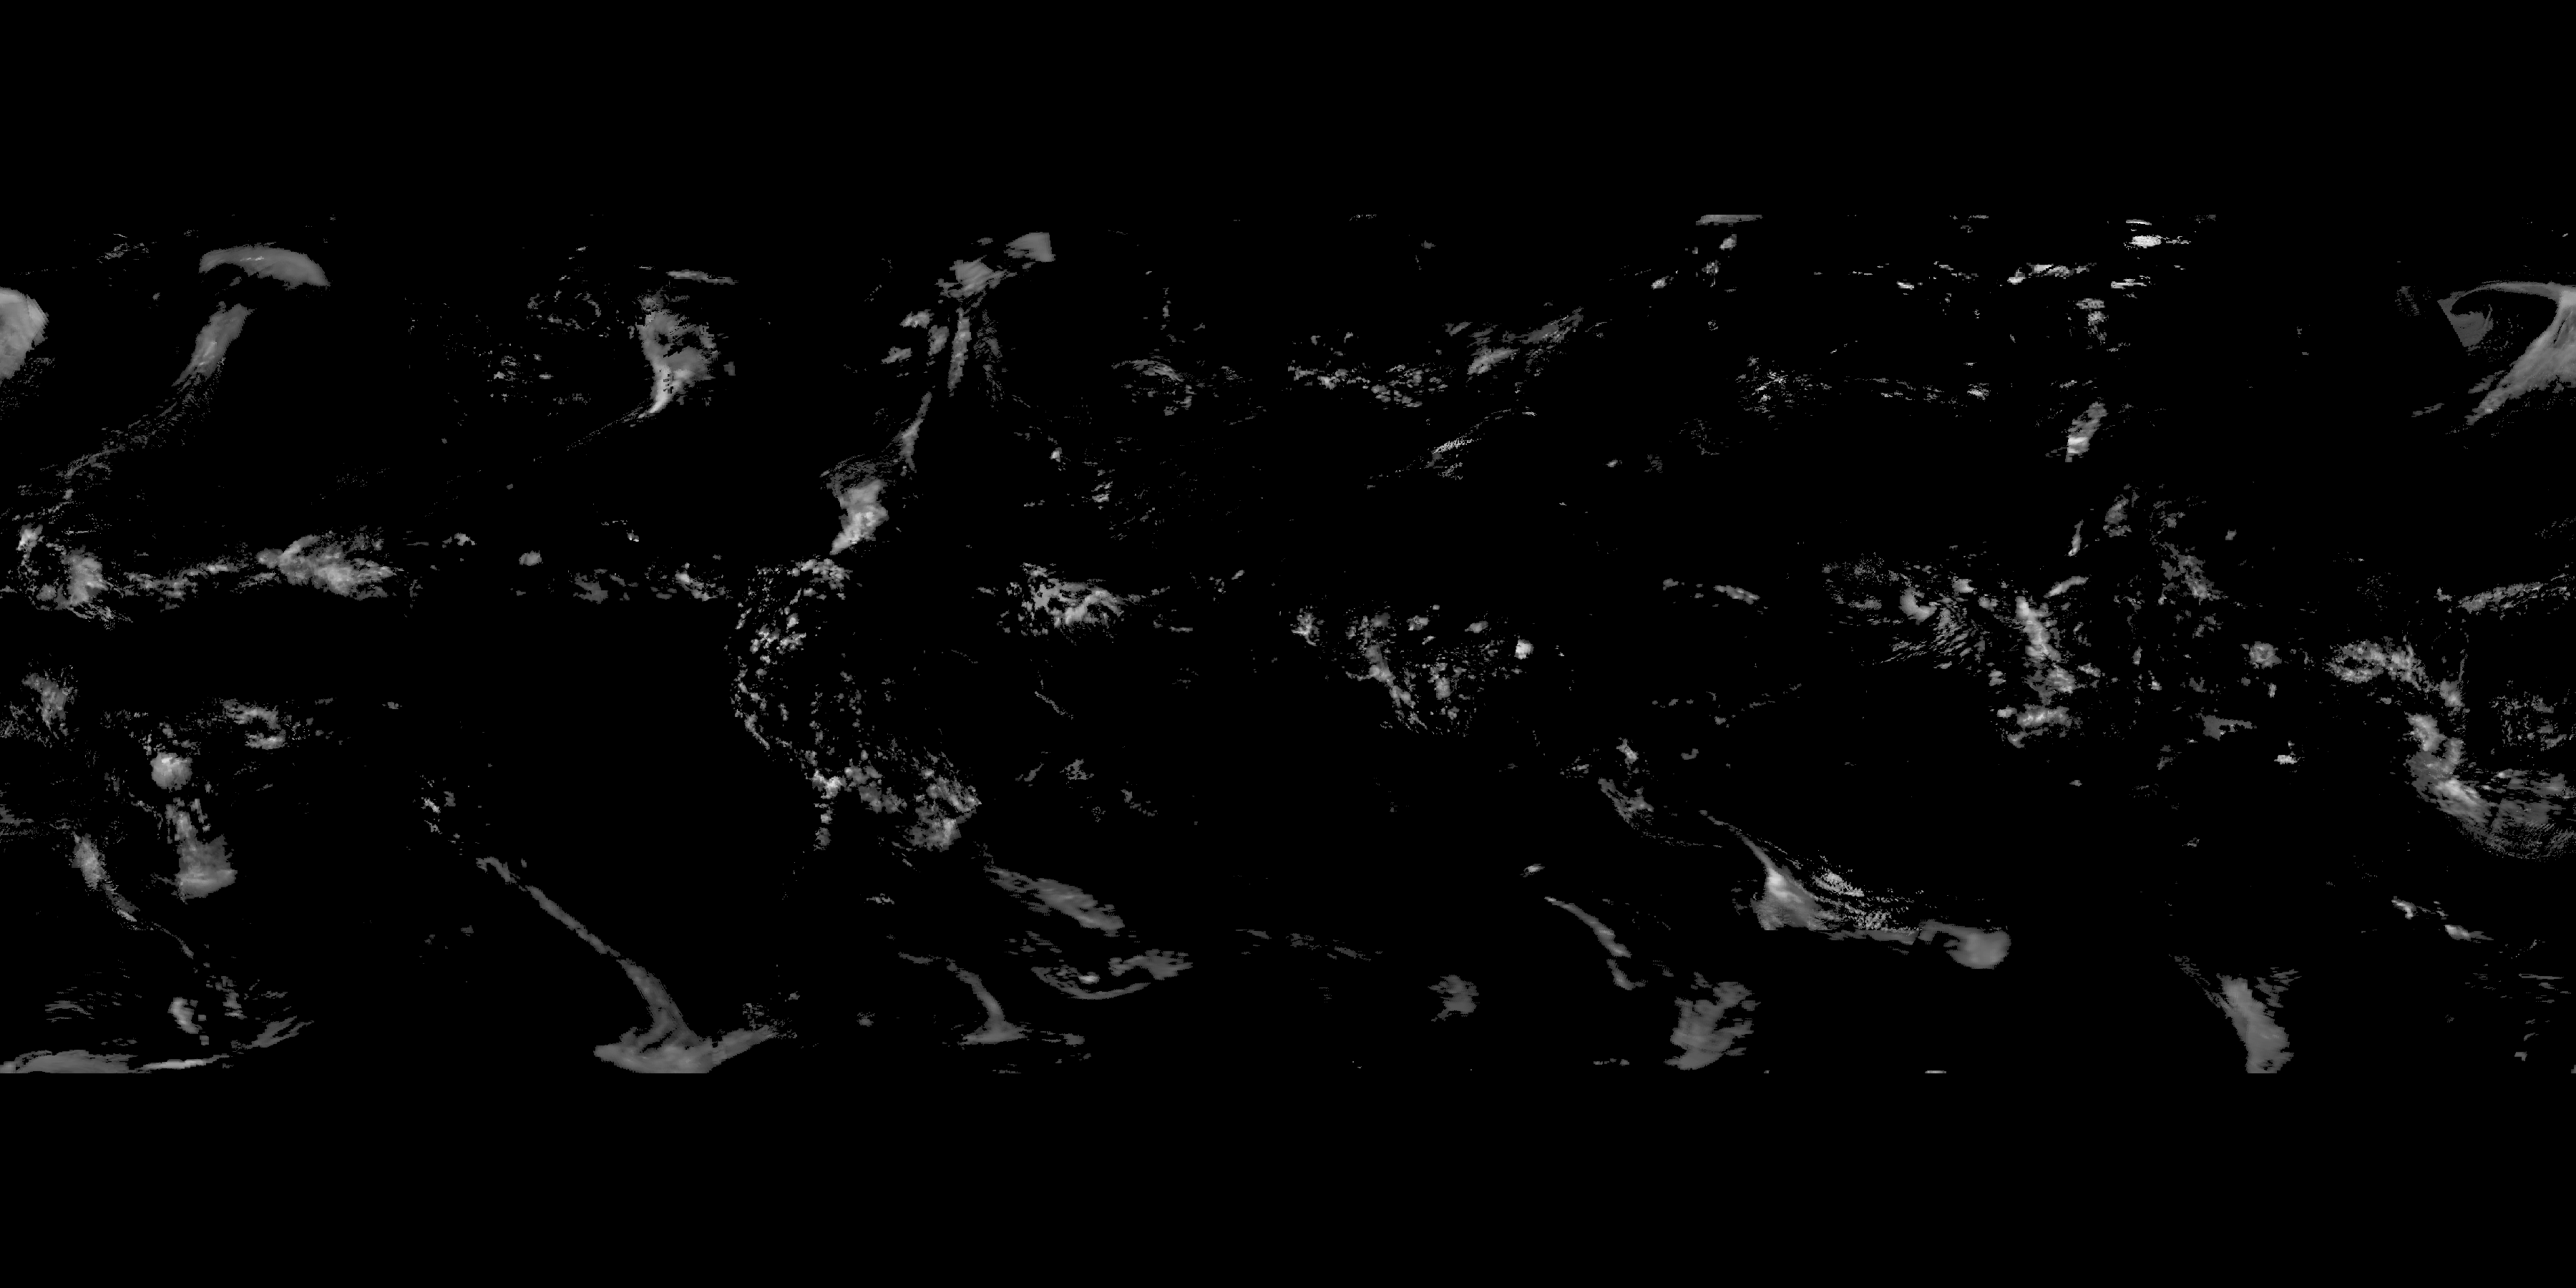

In [113]:
# Test get_total_precipitation by comparing its output with the movie here:
# http://svs.gsfc.nasa.gov/cgi-bin/details.cgi?aid=4285
from PIL import Image, ImageDraw
def exp_normalize(arr, exp=1.0):
    """
    Convert an array to zero to one values, where one corresponds to the max value,
    then apply an exponential function to adjust the curve of the color ramp.
    """
    return (arr / arr.max()) ** exp
data = get_total_precipitation(
    datetime.datetime(2016, 11, 29),
    datetime.datetime(2016, 11, 29, 1))
im_array = np.array(exp_normalize(data.transpose()[::-1], .25) * 2 ** 8,
             dtype=np.uint8)
Image.fromarray(im_array, 'L')

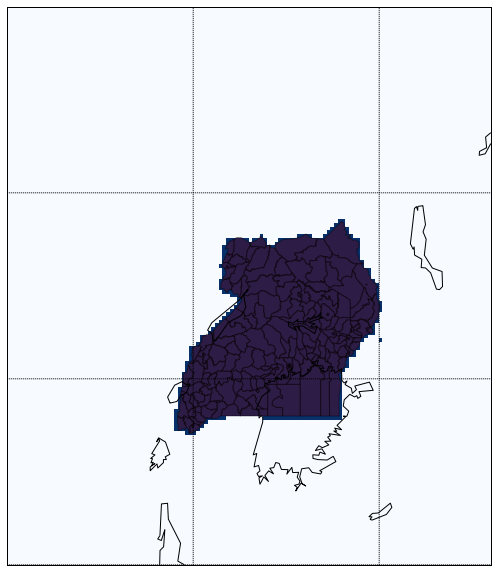

In [125]:
xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
nrows, ncols = np.shape(data.transpose())
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)
xy_to_raster_affine = Affine.from_gdal(xmin, xres, 0, ymax, 0, -yres)

def plot_uganda_district_rainfall(raster_data):
    m = Basemap(projection='cyl',
                llcrnrlon=25, llcrnrlat=-5,
                urcrnrlon=38, urcrnrlat=10,
                resolution='l')
    fig = plt.figure(figsize=(10,10))
    # The lat/lons for pcolormesh need to be for the top-left corner
    # of the grid cell.
    dlon = (lons[-1]-lons[0]) / len(lons[1:])
    dlat = (lats[-1]-lats[0]) / len(lats[1:])
    lons2, lats2 = np.meshgrid(
        np.arange(lons[0], lons[-1] + dlon, dlon) - (dlon / 2),
        np.arange(lats[0], lats[-1] + dlat, dlat) - (dlat / 2))
    m.pcolormesh(lons2,  lats2, exp_normalize(raster_data, .1).transpose(), cmap=plt.cm.Blues, latlon=True)
    ax = plt.gca()
    patches = []
    #add polygons
    zstats = zonal_stats(uganda_shapes,
        raster_data.transpose()[::-1],
        affine=xy_to_raster_affine,
        all_touched=True)
    max_mean = max([stat['mean'] for stat in zstats])
    for idx, dist in uganda_shapes.iterrows():
        poly = dist.geometry
        stats = zstats[idx]
        if poly.geom_type == 'Polygon':
            p = PolygonPatch(poly, facecolor=plt.cm.Reds((stats['mean'] / max_mean) ** .1), alpha=.4)
            patches.append(p)
    ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,80.,5.))
    m.drawmeridians(np.arange(-180.,180.,5.))
    return m

# Verify that plot_uganda_district_rainfall is accurate by using zonal_stats's underlying functions
# to draw the Uganda district shapes on a raster then plot it.
from rasterio import features
from rasterstats.io import read_features
from shapely.geometry import shape
rv_array = features.rasterize(
    [shape(feature['geometry']) for feature in read_features(uganda_shapes)],
    out_shape=data.transpose().shape,
    transform=xy_to_raster_affine,
    fill=255,
    dtype='uint8',
    all_touched=True)
plot_uganda_district_rainfall(np.array(~rv_array, dtype=np.float32)[::-1].transpose() / 255)

In [111]:
# Check that the pixel at the lat/lng for the Kitale Weather Station is filled
~rv_array[::-1][(lats >= 1) & (lats <= 1.2), :][:, (lons >= 35) & (lons <= 35.2)]

array([[254,   0],
       [  0,   0]], dtype=uint8)

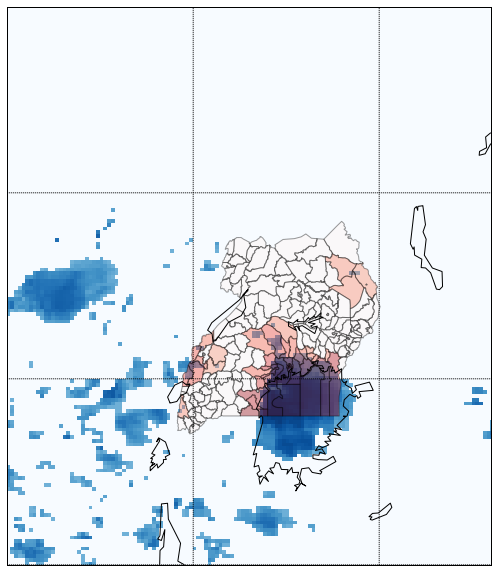

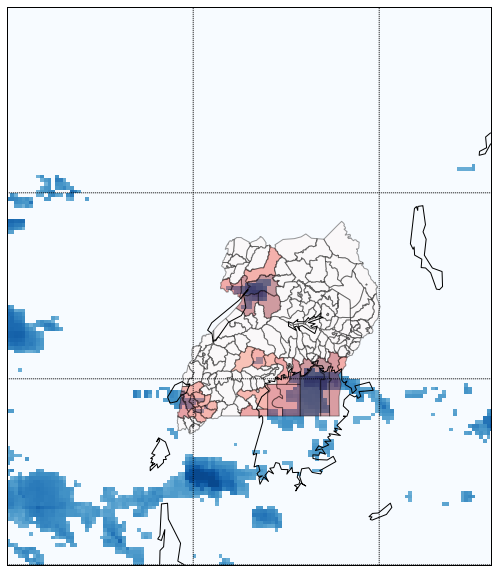

In [132]:
# Test zone stats by sumperimposing uganda district choropleth onto rainfall raster.
# The shade of each district should correspond to the number and intensity of the
# blue rainfall pixels overlapping it.
data = get_total_precipitation(datetime.datetime(2016, 11, 29), datetime.datetime(2016, 11, 29,1))
print(plot_uganda_district_rainfall(data))
data2 = get_total_precipitation(datetime.datetime(2016, 11, 2), datetime.datetime(2016, 11, 2, 1))
print(plot_uganda_district_rainfall(data2))

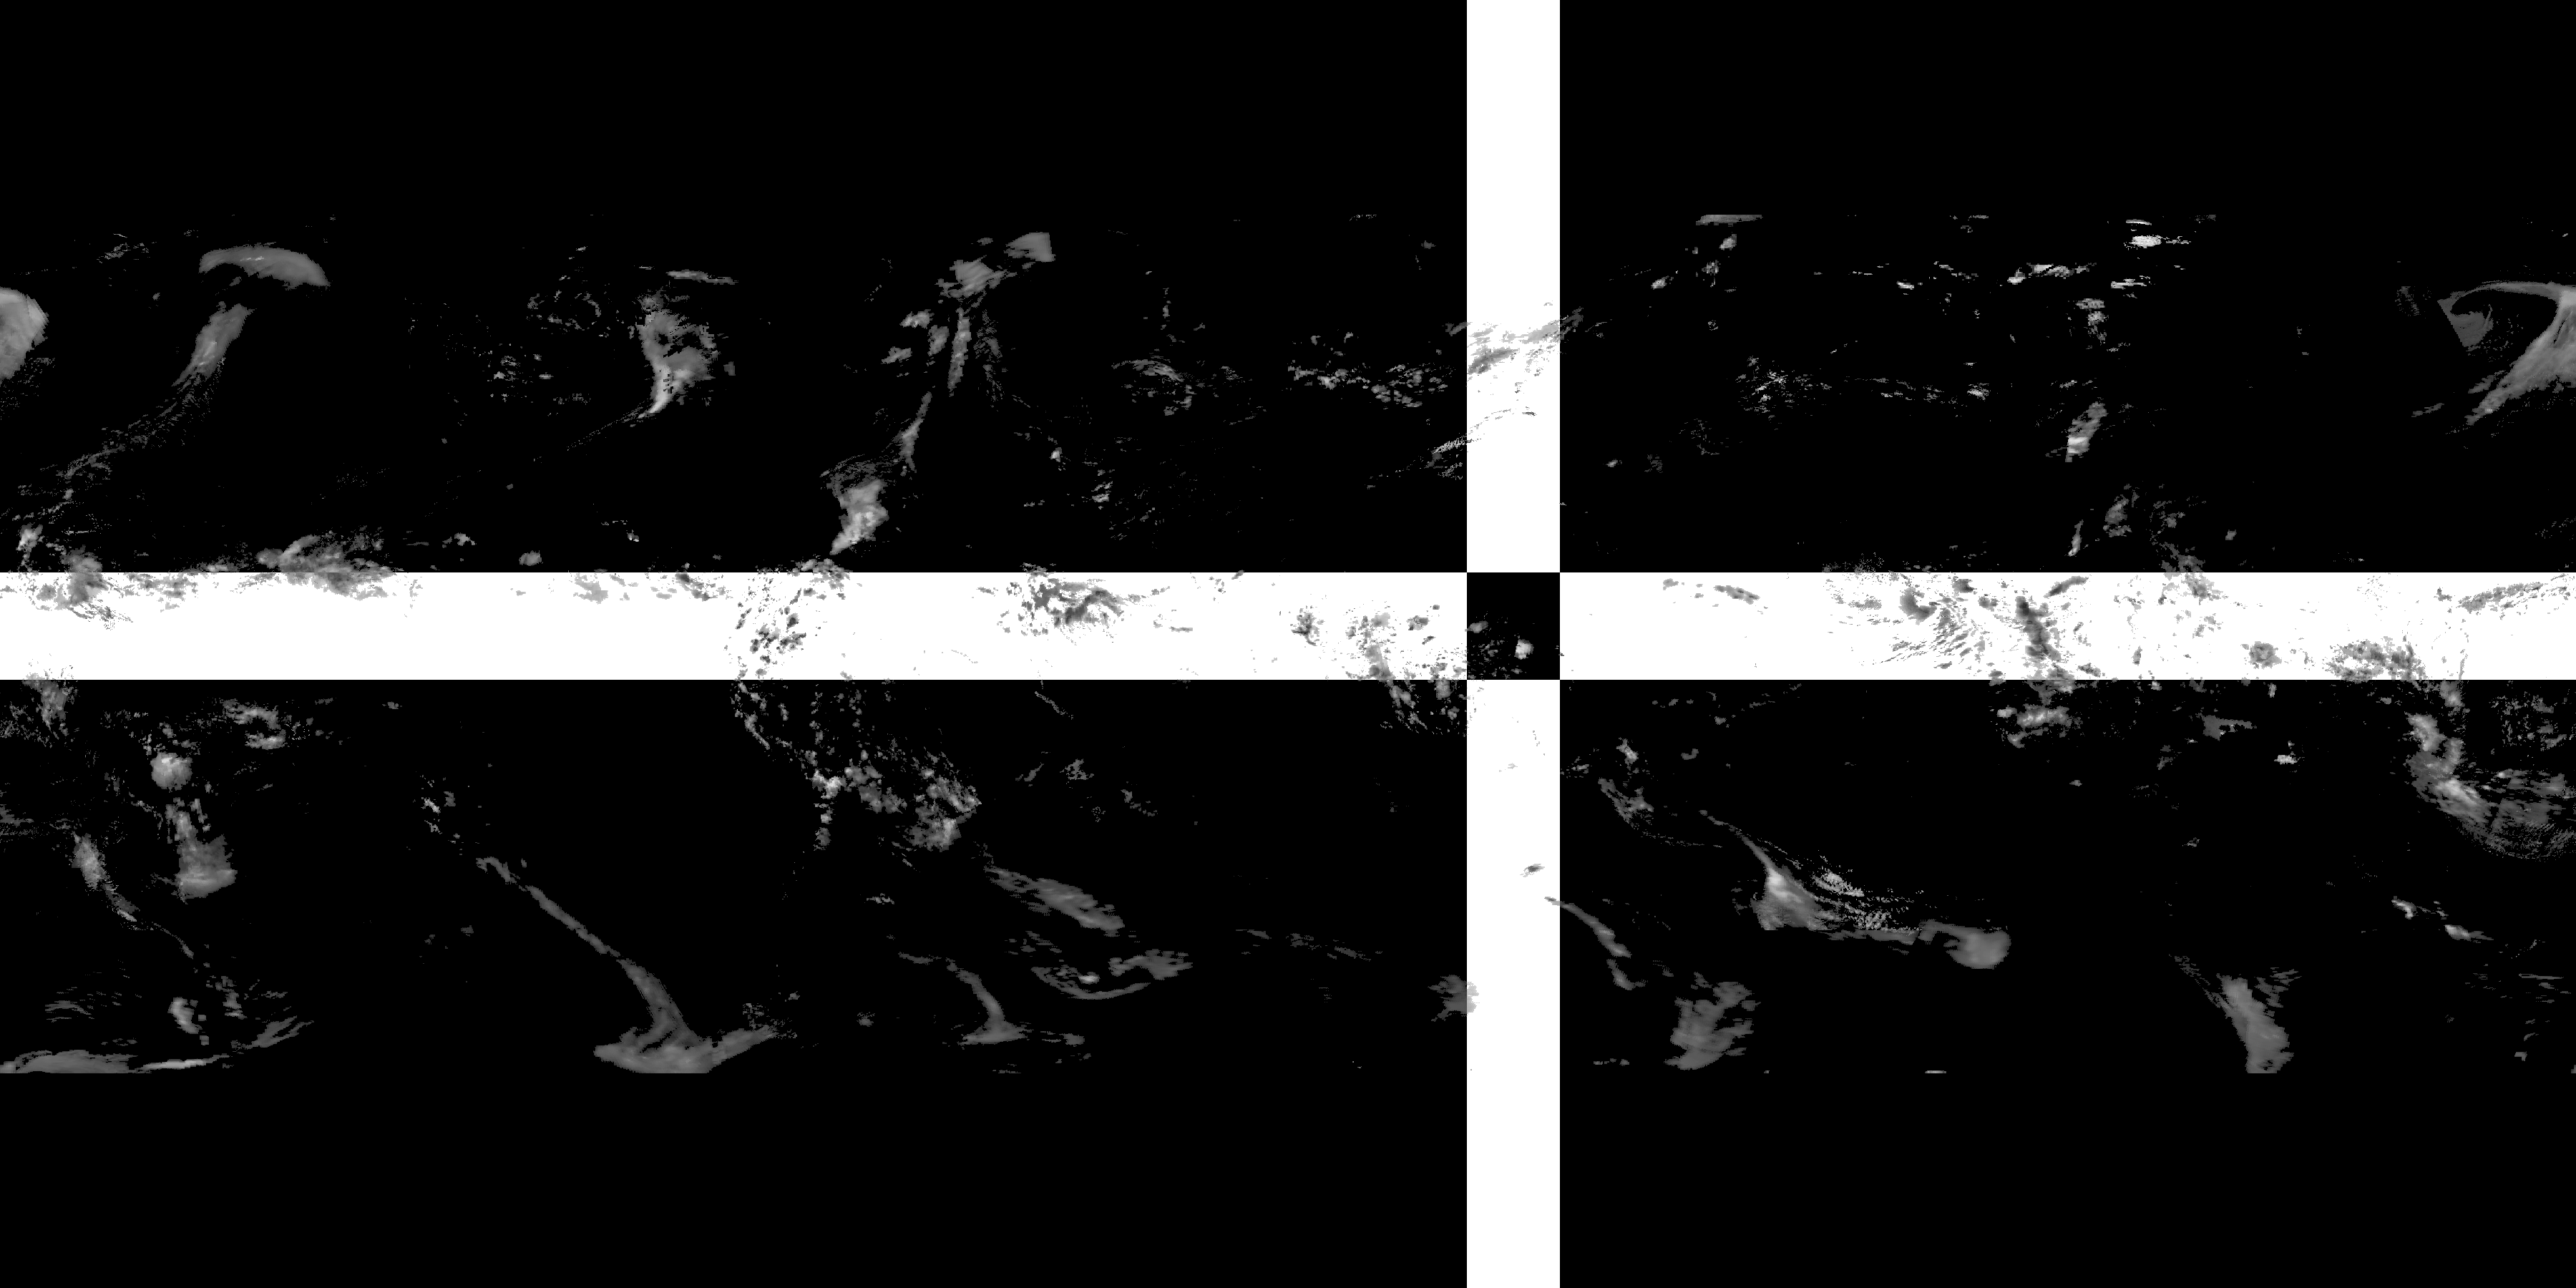

In [182]:
# Highlight the basemap region on the original raster image to verify its alignment
data = get_total_precipitation(
    datetime.datetime(2016, 11, 29),
    datetime.datetime(2016, 11, 29, 1))
im_array = np.array((data / data.max())  ** .25 * 2 ** 8,
             dtype=np.uint8)
im_array[:, (lats > -5) & (lats < 10)] ^= 255
im_array[(lons > 25) & (lons < 38), :] ^= 255
Image.fromarray(im_array.transpose()[::-1], 'L')

In [ ]:
# Create a time series of precipitation by district with ticks for each day.
timeseries = []
for day in pd.date_range('4/1/2015', '11/20/2016', freq='D'):
    data = get_total_precipitation(
        pd.to_datetime(day),
        pd.to_datetime(day) + datetime.timedelta(1))
    #print day
    print(".", end='')
    zstats = zonal_stats(uganda_shapes,
        data.transpose()[::-1],
        affine=xy_to_raster_affine,
        all_touched=True)
    for idx, row in uganda_shapes.iterrows():
        zstats[idx]['ADM_NAME'] = row.ADM1_NAME + '.' + row.ADM2_NAME
        zstats[idx]['date'] = day
    timeseries.extend(zstats)

/aux/GPM/201505/3B-HHR-E.MS.MRG.3IMERG.20150515-S130000-E132959.0780.V03E.RT-H5 False
/aux/GPM/201505/3B-HHR-E.MS.MRG.3IMERG.20150515-S133000-E135959.0810.V03E.RT-H5 False
/aux/GPM/201505/3B-HHR-E.MS.MRG.3IMERG.20150515-S140000-E142959.0840.V03E.RT-H5 False
/aux/GPM/201505/3B-HHR-E.MS.MRG.3IMERG.20150515-S143000-E145959.0870.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150611-S210000-E212959.1260.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150611-S213000-E215959.1290.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150611-S220000-E222959.1320.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150611-S223000-E225959.1350.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150623-S070000-E072959.0420.V03E.RT-H5 False
/aux/GPM/201506/3B-HHR-E.MS.MRG.3IMERG.20150623-S073000-E075959.0450.V03E.RT-H5 False
/aux/GPM/201603/3B-HHR-E.MS.MRG.3IMERG.20160312-S120000-E122959.0720.V03E.RT-H5 False
/aux/GPM/201603/3B-HHR-E.MS.MRG.3IMERG.20160312-S12300

In [126]:
# Convert timeseries to dataframe, add computed columns, and save pickled version.
timeseries = pd.DataFrame(timeseries)
timeseries['month'] = timeseries.date.map(lambda x: "%4d-%02d" % (x.year, x.month))
# Arbitrary threshold
timeseries['rainy_day'] = timeseries['mean'] > 1.0
timeseries.to_pickle('GPM-timeseries-by-district-uganda.p')

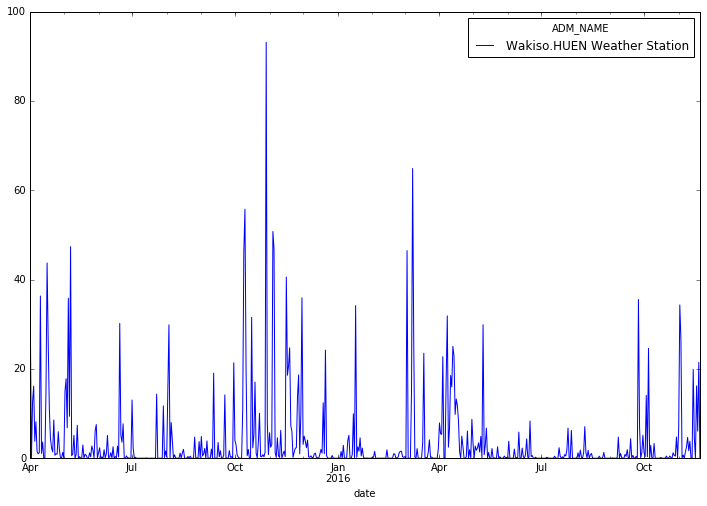

In [127]:
# Daily rainfall over HUEN Weather station region.
d = pd.DataFrame(timeseries)
d = d[d.ADM_NAME.str.startswith('Wakiso.HUEN')]
d.groupby(['ADM_NAME', 'date']).sum().reset_index().pivot(
    index='date', columns='ADM_NAME', values='mean'
).plot(figsize=(12, 8))

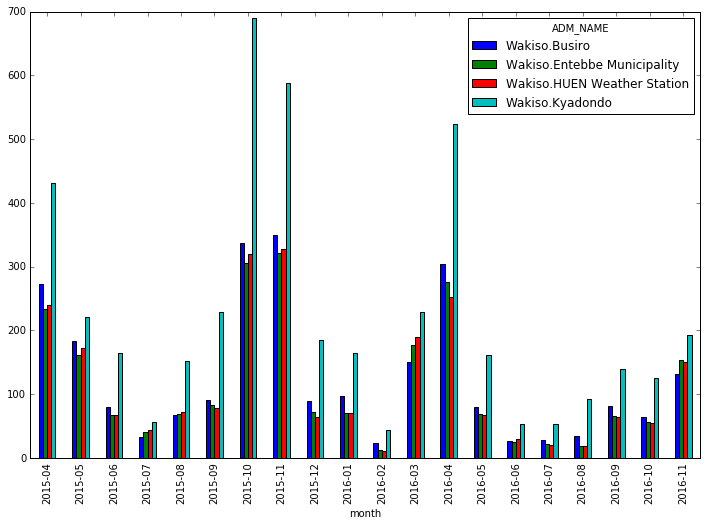

In [128]:
# Monthly rainfall comparison for Wakiso districts.
d = pd.DataFrame(timeseries)
d = d[d.ADM_NAME.str.startswith('Wakiso')]
d.groupby(['ADM_NAME', 'month']).sum().reset_index().pivot(
    index='month', columns='ADM_NAME', values='mean'
).plot(kind='bar', figsize=(12, 8))

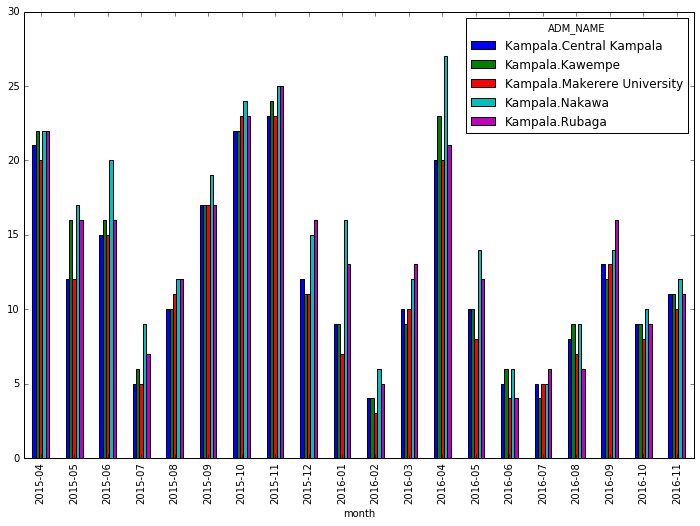

In [129]:
# Number of rainy days per month in Kampala districts.
d = pd.DataFrame(timeseries)
d = d[d.ADM_NAME.str.startswith('Kampala')]
d.groupby(['ADM_NAME', 'month']).sum().reset_index().pivot(
    index='month', columns='ADM_NAME', values='rainy_day'
).plot(kind='bar', figsize=(12, 8))

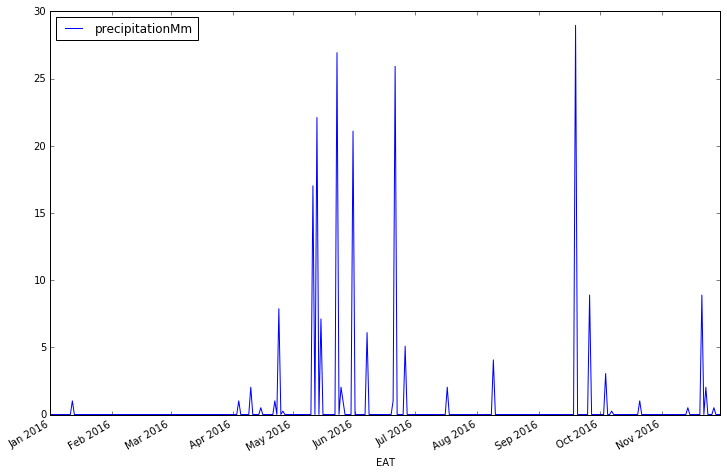

In [130]:
# Use data from HUEN weather station in Entebbe to cross-check satalite data
# Data source: https://www.wunderground.com/history/airport/HUEN
weather_station_data = pd.read_csv("HUEN.csv", converters=dict(
    EAT=pd.to_datetime
)).set_index("EAT")
weather_station_data['month'] = weather_station_data.index.map(lambda x: "%4d-%02d" % (x.year, x.month))
weather_station_data['precipitationMm'] = weather_station_data.PrecipitationIn * 25.4
weather_station_data[['precipitationMm']].plot(kind='line', figsize=(12, 8))

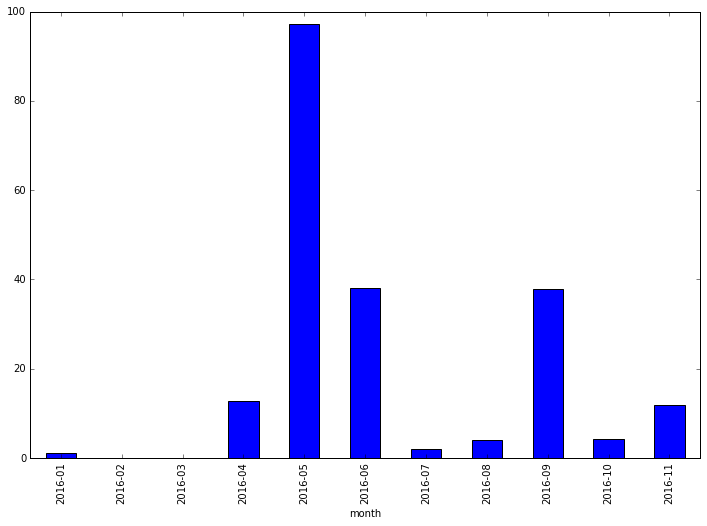

In [131]:
# Montly precipitation
d = pd.DataFrame(weather_station_data)
d.groupby(['month']).sum()['precipitationMm'].plot(kind='bar', figsize=(12, 8))

The HUEN data shows quite a bit less precipitation than the GPM satellite, and many of the peaks do not match up.

This website shows Entebbe's average yearly rainfall. It is closer the the satellite data than the HUEN data in magnitude:
https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine,entebbe,Uganda

The wolfram alpha data for Entebbe precipitation does not appear to match up perfectly with the satellite data. It mentions the HUEN weather station. It is closer in magnitude to the satellite data than the weather station data:
http://www.wolframalpha.com/input/?i=entebbe+rainfall+by+month

# Useful links:
https://github.com/geopandas/geopandas/blob/master/examples/choropleths.ipynb
https://github.com/davidbrochart/gross/blob/8c1111b87b87b57fa3462abb1a19bb95d94ccac1/ipynb/amazon1.ipynb
https://github.com/JacksonTanBS/iPythonNotebooks/blob/master/150528%20How%20Much%20of%20Earth%20is%20Raining%20at%20Any%20One%20Time.ipynb
http://earthpy.org/pandas-basics.html
https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/
